<a href="https://colab.research.google.com/github/LinaMariaCastro/curso-ia-para-economia/blob/main/clases/5_Aprendizaje_supervisado/4_Taller_KNN_y_Arboles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inteligencia Artificial con Aplicaciones en Economía I**

- 👩‍🏫 **Profesora:** [Lina María Castro](https://www.linkedin.com/in/lina-maria-castro)  
- 📧 **Email:** [lmcastroco@gmail.com](mailto:lmcastroco@gmail.com)  
- 🎓 **Universidad:** Universidad Externado de Colombia - Facultad de Economía

# **Taller KNN y Árboles de Decisión**

**IMPORTANTE**: Guarda una copia de este notebook en tu Google Drive o computador.

**Taller en parejas**

**Nombres estudiantes:**

- Dairon Ferney Reina Sabogal
-

**Forma de entrega**

Jupyter Notebook publicado en su cuenta de Github con el nombre “Taller_KNN_apellidos.ipynb”.

**Plazo de entrega**

6 de noviembre, máximo a las 11:59 p.m., debes enviar link del notebook al correo lina.castro6@uexternado.edu.co, de lo contrario, no será tenido en cuenta.

**Instrucciones Generales**

Completa el código en las celdas marcadas con `### TU CÓDIGO AQUÍ ###`. Puedes añadir más celdas si lo requieres.



### **Contexto del Caso**

Un banco portugués lo ha contratado como consultor de ciencia de datos. El banco tiene un problema de eficiencia: sus campañas de telemercadeo para ofrecer depósitos a plazo tienen una tasa de éxito muy baja. Se invierte mucho tiempo y recursos (costos de call center) llamando a clientes que no están interesados.

**Su misión:** Construir y optimizar modelos de Machine Learning que predigan qué clientes tienen mayor probabilidad de decir **"sí"** a la oferta (`y = 'yes'`).

El banco no solo quiere un modelo preciso, también quiere entender **POR QUÉ** un cliente es un buen prospecto. Su segundo objetivo es identificar cuáles son las **variables más relevantes** que usan los modelos para tomar sus decisiones. Esto permitirá al banco no solo enfocar sus llamadas, sino también crear mejores guiones de marketing y entender mejor a su clientela.

**El Dataset:** `bank-additional.csv` se encuentra en el repositorio del curso. Contiene información de más de 4.000 contactos de telemercadeo, incluyendo datos demográficos del cliente e información de la campaña (último contacto, resultado anterior).

**Para mayor información y descripción de las variables:** https://archive.ics.uci.edu/dataset/222/bank+marketing

## 1. Preparación del Entorno y Datos

### 1.1. Carga de Librerías

Importe todas las librerías necesarias. Para problemas de clasificación se usa KNeighborsClassifier y DecisionTreeClassifier.

In [1]:
### TU CÓDIGO AQUÍ ###
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier  # <--- Versión de Regresión
from sklearn.tree import DecisionTreeClassifier, plot_tree # <--- Versión de Regresión
from sklearn.metrics import mean_squared_error, r2_score # <--- Métricas de Regresión
from sklearn.inspection import permutation_importance # <--- Para Feature Importance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Mejorar visualización de dataframes y gráficos

In [2]:
# Que muestre todas las columnas
pd.options.display.max_columns = None
# En los dataframes, mostrar los float con dos decimales
pd.options.display.float_format = '{:,.2f}'.format

# Configuraciones para una mejor visualización
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### 1.2. Carga y Exploración Inicial

In [3]:
# 1.2.1: Cargue el dataset
# ### TU CÓDIGO AQUÍ ###
# Usa sep=';'
path = r'C:\Users\Ferney Reina\Documents\Python\IA_Economia\2025-segundo-semestre-ia-economia\datasets'
os.chdir(path)
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.drop(columns=['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], inplace=True)

# 1.2.2: Muestre las primeras 5 filas
# ### TU CÓDIGO AQUÍ ###
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,no


In [4]:
# 1.2.3: Use .info() para revisar los tipos de datos y los nulos
# ### TU CÓDIGO AQUÍ ###
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          41188 non-null  int64 
 1   job          41188 non-null  object
 2   marital      41188 non-null  object
 3   education    41188 non-null  object
 4   default      41188 non-null  object
 5   housing      41188 non-null  object
 6   loan         41188 non-null  object
 7   contact      41188 non-null  object
 8   month        41188 non-null  object
 9   day_of_week  41188 non-null  object
 10  campaign     41188 non-null  int64 
 11  pdays        41188 non-null  int64 
 12  previous     41188 non-null  int64 
 13  poutcome     41188 non-null  object
 14  y            41188 non-null  object
dtypes: int64(4), object(11)
memory usage: 4.7+ MB


**Escriba un análisis de lo obseervado en `info()`:**
Dado el tipo de datos de la base, qué preprocesamientos hay que realizar antes de correr los modelos?

In [5]:
# 1.2.4: Revise el balance de la variable objetivo 'y'
# Use .value_counts() con normalize=True

# ### TU CÓDIGO AQUÍ ###
df['y'].value_counts(normalize=True)

y
no    0.89
yes   0.11
Name: proportion, dtype: float64

**Escriba un análisis de la variable objetivo:**
¿Es un dataset desbalanceado? ¿Esto tiene lógica? ¿Qué implicaciones tiene esto respecto a las métricas que debemos usar?

Rta: El dataset está desbalanceado, ya que solo el 11% de los clientes suscribieron el depósito, lo cual es lógico en campañas bancarias donde la mayoría no acepta la oferta. Este desbalance afecta la evaluación del modelo, por lo que métricas como la precisión global (accuracy) no son adecuadas; se deben usar métricas como F1-score, recall o AUC-ROC para medir el desempeño real.

## 2. Preprocesamiento (Usando Pipelines)

Vamos a definir nuestro `X` e `y`, y luego crear un `ColumnTransformer` que se encargue de aplicar `StandardScaler` a los números y `OneHotEncoder` a las categorías.

In [6]:
# 2.1: Separe X (predictoras) e y (objetivo)

# ### TU CÓDIGO AQUÍ ###
y = df['y']
X = df.drop(columns=['y'])

In [7]:
# 2.2: Divida en train y test (80/20)
# ¡Use stratify=y para mantener la proporción de 'yes' y 'no' en ambos sets!

# ### TU CÓDIGO AQUÍ ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño Train: {X_train.shape}")
print(f"Tamaño Test: {X_test.shape}")

Tamaño Train: (32950, 14)
Tamaño Test: (8238, 14)


In [8]:
# 2.3: Identifique automáticamente las columnas numéricas y categóricas

# ### TU CÓDIGO AQUÍ ###
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Columnas Numéricas:")
print(numerical_features)
print("\nColumnas Categóricas:")
print(categorical_features)

Columnas Numéricas:
['age', 'campaign', 'pdays', 'previous']

Columnas Categóricas:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [9]:
# 2.4: Cree el ColumnTransformer (preprocessor) para estandarizar las variables numéricas y
# realizar One-Hot-Encoding de las variables categóricas

# Crear los transformadores individuales
# ### TU CÓDIGO AQUÍ ###
numeric_transformer = StandardScaler()

# ### TU CÓDIGO AQUÍ ###
# handle_unknown='ignore' es clave
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Unirlos en el preprocesador usando ColumnTransformer
# ### TU CÓDIGO AQUÍ ###
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 3. Modelo 1: KNN

Ahora uniremos el preprocesador y el clasificador KNN en un solo `Pipeline` y usaremos `GridSearchCV` para encontrar el mejor `k`.

In [ ]:
# 3.1: Cree el Pipeline completo de KNN
# (una el 'preprocessor' con el modelo 'KNeighborsClassifier')

# ### TU CÓDIGO AQUÍ ###
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

# 3.2: Definir la grilla de hiperparámetros para KNN
# Queremos probar k = 3, 5, 7, 11 (valores impares para evitar empates)
# Pista: El nombre DEBE ser 'model__n_neighbors' (por el nombre en el pipeline)

# ### TU CÓDIGO AQUÍ ###
param_grid_knn = {
    'model__n_neighbors': [3, 5, 7, 11]
}

# 3.3: Configurar y ejecutar GridSearchCV
# Use 3 folds (cv=3) para que corra más rápido.
# Use scoring='recall_macro'.

# ### TU CÓDIGO AQUÍ ###
grid_knn = GridSearchCV(estimator=knn_pipeline,
                            param_grid=param_grid_knn,
                            scoring='recall_macro',
                            cv=3,
                            n_jobs=-1)
grid_knn.fit(X_train, y_train)



# 3.4: Mostrar los mejores resultados
print(f"Mejor valor de 'k' para KNN: {grid_knn.best_params_} ")
print(f"Mejor Recall-Macro: {grid_knn.best_score_:.4f}")

Mejor valor de 'k' para KNN: {'model__n_neighbors': 7}
Mejor Recall-Macro: 0.5977


## 4. Modelo 2: Árbol de Decisión

Repetiremos el proceso con un Árbol de Decisión. Esta vez, los hiperparámetros que ajustaremos serán `max_depth` (para evitar sobreajuste) y `min_samples_leaf`.

In [16]:
# 4.1: Crear el Pipeline completo para el Árbol de Decisión
# (une el 'preprocessor' con el modelo 'DecisionTreeClassifier')

# ### TU CÓDIGO AQUÍ ###
tree_pipeline = Pipeline(steps=[ 
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(random_state=42))
])

# 4.2: Definir la grilla de hiperparámetros para el Árbol
# Probaremos 'max_depth' = [3, 5, 7]
# Y 'min_samples_leaf' = [20, 50, 100] (para controlar la complejidad)

# ### TU CÓDIGO AQUÍ ###
param_grid_tree = {
    'model__max_depth': [3, 5, 7],
    'model__min_samples_leaf': [20, 50, 100] 
}

# 4.3: Configurar y ejecutar GridSearchCV
# Al igual que en KNN, use 3 folds (cv=3) para que corra más rápido.
# Use scoring='recall_macro'.
# ### TU CÓDIGO AQUÍ ###
grid_tree = GridSearchCV(estimator=tree_pipeline,
                         param_grid=param_grid_tree,
                         scoring='recall_macro',
                         cv=3)
grid_tree.fit(X_train, y_train)


# 4.4: Mostrar los mejores resultados
print(f"Mejores hiperparámetros para el Árbol: {grid_tree.best_params_}")
print(f"Mejor Recall-Macro: {grid_tree.best_score_:.4f}")

Mejores hiperparámetros para el Árbol: {'model__max_depth': 7, 'model__min_samples_leaf': 20}
Mejor Recall-Macro: 0.5935


## 5. Evaluación Final y Recomendación de Modelo

El Árbol de Decisión probablemente dio un mejor `recall-macro` (y es más rápido e interpretable). Vamos a declararlo nuestro **modelo ganador** y evaluarlo en el `test set` (nuestro examen final imparcial).

In [18]:
# 5.1: Obtener el mejor modelo de árbol (el 'best_estimator_')

# ### TU CÓDIGO AQUÍ ###
best_tree_model = grid_tree.best_estimator_

# 5.2: Realizar predicciones sobre el conjunto de PRUEBA (X_test)

# ### TU CÓDIGO AQUÍ ###
y_pred_tree = best_tree_model.predict(X_test)

# 5.3: Imprimir el Reporte de Clasificación
print("--- Reporte de Clasificación Final (Árbol Optimizado) ---")

# ### TU CÓDIGO AQUÍ ###
print(classification_report(y_test, y_pred_tree))

--- Reporte de Clasificación Final (Árbol Optimizado) ---
              precision    recall  f1-score   support

          no       0.91      0.99      0.95      7310
         yes       0.66      0.19      0.30       928

    accuracy                           0.90      8238
   macro avg       0.79      0.59      0.62      8238
weighted avg       0.88      0.90      0.87      8238



**Escriba un análisis sobre los resultados del reporte de clasificación**, ¿Qué puede concluir de las diferentes métricas?

* Observe el `accuracy` general (probablemente ~90%).
* Ahora mire la fila de `'yes'`: ¿Cuál es el `precision`? ¿Cuál es el `recall`?
* **Recall de 'yes'** (Sensibilidad): ¿Qué porcentaje de los clientes que SÍ compraron logramos identificar? (Usualmente lo más importante para el banco, para no perder oportunidades).
* **Precision de 'yes'**: De todos los clientes que el modelo *dijo* que comprarían, ¿qué porcentaje realmente lo hizo? (Importante para no gastar llamadas).

**Responda aquí**

El modelo presenta una accuracy del 90%, lo que parece alto, pero está influido por el desbalance del dataset, ya que la mayoría de los clientes no suscriben el depósito. En la clase ‘yes’, el precision (0.66) indica que el 66% de los clientes que el modelo predijo como interesados realmente lo estaban, mientras que el recall (0.19) muestra que solo se identificó al 19% de los clientes que efectivamente aceptaron. Esto significa que el modelo pierde muchas oportunidades reales, por lo que, aunque es preciso al elegir a quién contactar, no detecta a la mayoría de los clientes potenciales, limitando su utilidad para una campaña de marketing.

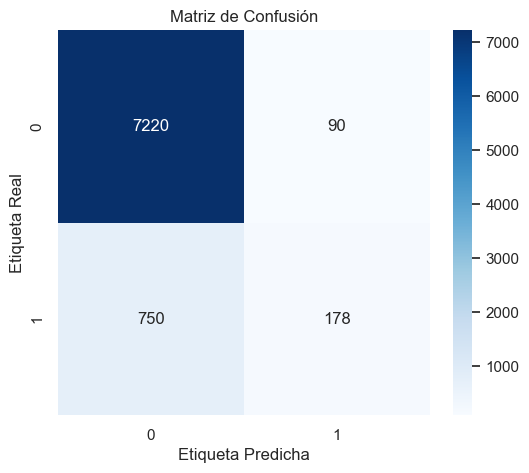

In [21]:
# 5.4: Grafique la Matriz de Confusión
# ### TU CÓDIGO AQUÍ ###

cm = confusion_matrix(y_test, y_pred_tree)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()

## 6. ¿Cuáles son las Variables Más Relevantes?

Esta es la segunda parte de la solicitud del banco. Necesitamos explicar *por qué* el modelo toma sus decisiones.

### 6.1. Importancia de Variables (Árbol de Decisión)

In [22]:
# 6.1.1: Extraer el modelo de árbol y el preprocesador del pipeline optimizado
# (Ya tenemos 'best_tree_model')
# ### TU CÓDIGO AQUÍ ###
final_tree_model = best_tree_model.named_steps['model']
final_preprocessor = best_tree_model.named_steps['preprocessor']

# 6.1.2: Obtener los nombres de las características DESPUÉS del OneHotEncoding
# ### TU CÓDIGO AQUÍ ###
ohe = final_preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + ohe_feature_names.tolist()

# 6.1.3: Obtener las importancias (del 'final_tree_model')
# ### TU CÓDIGO AQUÍ ###
importances = final_tree_model.feature_importances_

# 6.1.4: Crear un DataFrame para visualizarlas, ordene de mayor a menor importancia
# ### TU CÓDIGO AQUÍ ###
tree_importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
print(tree_importances_df.head())

     Feature  Importance
0      pdays        0.57
1        age        0.10
2  month_mar        0.06
3  month_oct        0.06
4  month_jun        0.05


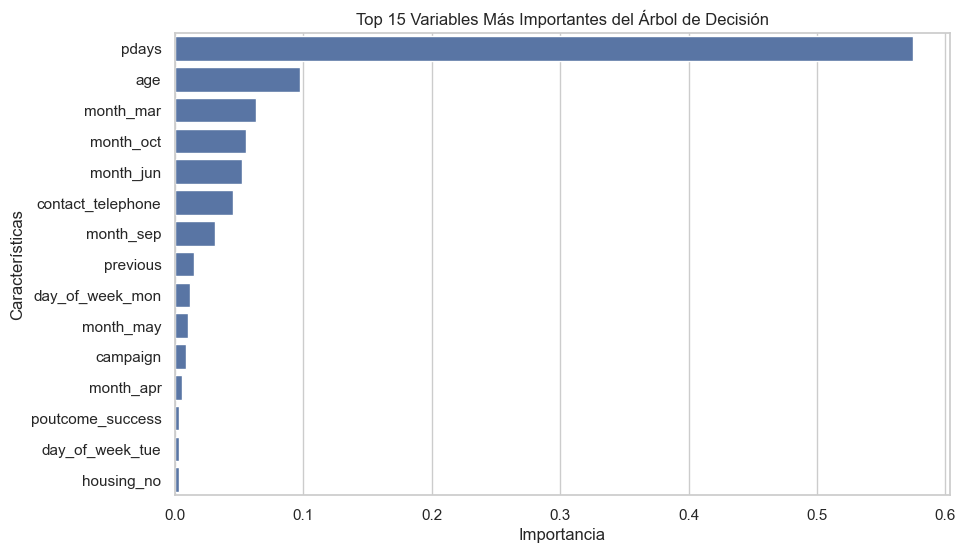

In [ ]:
# 6.1.5: Grafique las 15 variables más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=tree_importances_df.head(15))
plt.title('Top 15 Variables Más Importantes del Árbol de Decisión')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()

## 7. Conclusión y Recomendación de Negocio

Es hora de traducir nuestros hallazgos en una recomendación de negocio clara.

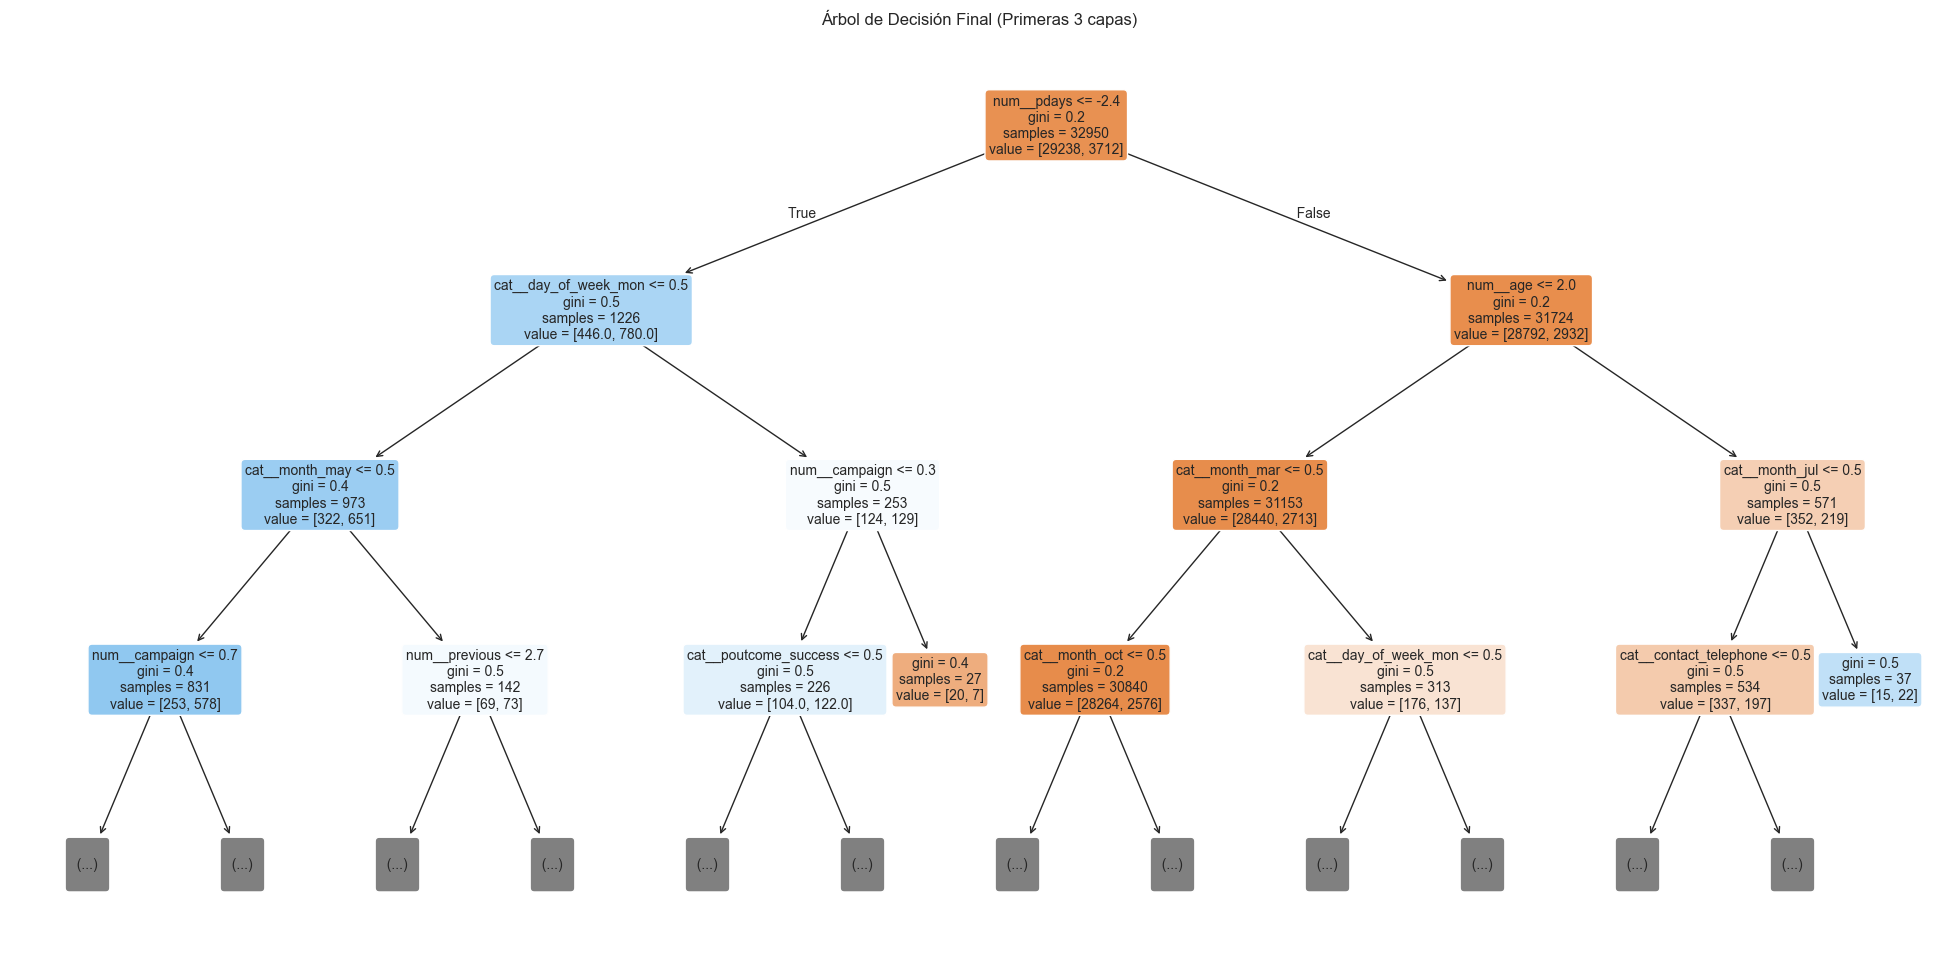

In [25]:
# 7.1: Grafique el árbol de decisión final para encontrar reglas
# (Use max_depth=3 para que sea legible)
# ### TU CÓDIGO AQUÍ ###
arbol = final_preprocessor.get_feature_names_out()

plt.figure(figsize=(25, 12))
plot_tree(
    final_tree_model,
    feature_names=arbol,
    max_depth=3,
    filled=True,
    rounded=True,
    fontsize=10,
    precision=1
)
plt.title('Árbol de Decisión Final (Primeras 3 capas)')
plt.show()

### **7.2: Conclusiones Consultoría**

Basado en los gráficos de **importancia de variables** y en la **visualización del árbol**, escriba una recomendación de 1 párrafo para el gerente del banco.

**Puntos a incluir:**
1.  ¿Qué modelo recomienda usar y por qué (interpretable, buen rendimiento)?
2.  ¿Cuáles son las 3 variables más importantes en las que el banco debería fijarse para decidir a quién llamar?
3.  Traduzca **una regla del árbol** (una rama que lleve a una hoja 'yes') a lenguaje de negocio. (Ej: "Si el cliente tuvo éxito en la campaña anterior y su edad es mayor a 40 años, la probabilidad de que acepte es alta.")


Recomiendo al banco mantener el **modelo de Árbol de Decisión**, ya que ofrece un buen equilibrio entre rendimiento (90% de precisión) e interpretabilidad, permitiendo explicar fácilmente las decisiones a nivel de negocio. Las tres variables más relevantes para seleccionar clientes son “**pdays**” (días desde el último contacto), “**age**” (edad del cliente) y el mes de contacto. Por ejemplo, una de las reglas del árbol indica que si el cliente no ha sido contactado recientemente, tiene una edad media-baja y fue llamado en marzo, la probabilidad de que acepte el depósito a plazo fijo aumenta significativamente, lo que orienta al banco sobre a quién priorizar en futuras campañas.